# Rozdział 19. Optymalizacja kodu

In [1]:
import numba

In [2]:
import pyximport

In [3]:
import cython

In [4]:
import numpy as np

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

# Numba

In [6]:
np.random.seed(0)

In [7]:
data = np.random.randn(50000)

In [8]:
def py_sum(data):
    s = 0
    for d in data:
        s += d
    return s

In [9]:
def py_cumsum(data):
    out = np.zeros(len(data))
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

In [10]:
%timeit py_sum(data)

13 ms ± 3.75 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [11]:
assert abs(py_sum(data) - np.sum(data)) < 1e-10

In [12]:
%timeit np.sum(data)

30.7 µs ± 2.46 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [13]:
%timeit py_cumsum(data)

19.8 ms ± 2.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
assert np.allclose(np.cumsum(data), py_cumsum(data))

In [15]:
%timeit np.cumsum(data)

167 µs ± 8.78 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [16]:
@numba.jit
def jit_sum(data):
    s = 0 
    for d in data:
        s += d

    return s

In [17]:
assert abs(jit_sum(data) - np.sum(data)) < 1e-10

In [18]:
%timeit jit_sum(data)

68.2 µs ± 958 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [19]:
jit_cumsum = numba.jit()(py_cumsum)

In [20]:
assert np.allclose(np.cumsum(data), jit_cumsum(data))

In [21]:
%timeit jit_cumsum(data)

79.2 µs ± 2.05 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Fraktal Julii

In [22]:
def py_julia_fractal(z_re, z_im, j):
    for m in range(len(z_re)):
        for n in range(len(z_im)):
            z = z_re[m] + 1j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if np.abs(z) > 2.0:
                #if (z.real * z.real + z.imag * z.imag) > 4.0:  # Szybszy wariant
                    j[m, n] = t
                    break

In [23]:
jit_julia_fractal = numba.jit(nopython=True)(py_julia_fractal)

In [24]:
N = 1024
j = np.zeros((N, N), np.int64)
z_real = np.linspace(-1.5, 1.5, N)
z_imag = np.linspace(-1.5, 1.5, N)

In [25]:
jit_julia_fractal(z_real, z_imag, j)

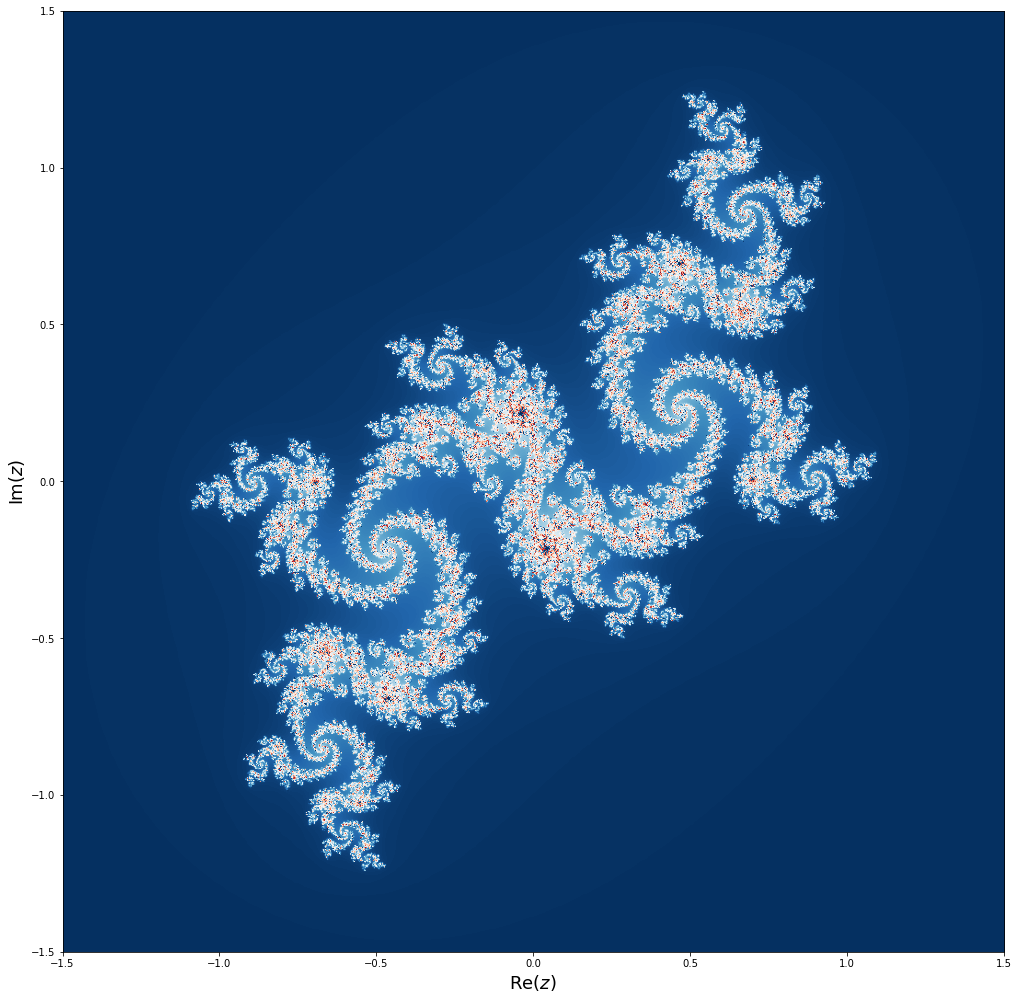

In [26]:
fig, ax = plt.subplots(figsize=(14, 14))
ax.imshow(j, cmap=plt.cm.RdBu_r,
          extent=[-1.5, 1.5, -1.5, 1.5])
ax.set_xlabel("$\mathrm{Re}(z)$", fontsize=18)
ax.set_ylabel("$\mathrm{Im}(z)$", fontsize=18)
fig.tight_layout()
fig.savefig("ch19-numba-julia-fractal.pdf")

In [27]:
%timeit py_julia_fractal(z_real, z_imag, j)

1min 4s ± 9.55 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [28]:
%timeit jit_julia_fractal(z_real, z_imag, j)

127 ms ± 1.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## numba.vectorize

In [29]:
def py_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0.0:
        return 0.0
    else:
        return 1.0

In [30]:
x = np.linspace(-2, 2, 50001)

In [31]:
%timeit [py_Heaviside(xx) for xx in x]

15.7 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [32]:
np_vec_Heaviside = np.vectorize(py_Heaviside)

In [33]:
np_vec_Heaviside(x)

array([0., 0., 0., ..., 1., 1., 1.])

In [34]:
%timeit np_vec_Heaviside(x)

7.16 ms ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [35]:
def np_Heaviside(x):
    return (x > 0.0) + (x == 0.0)/2.0

In [36]:
%timeit np_Heaviside(x)

135 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [37]:
@numba.vectorize([numba.float32(numba.float32),
                  numba.float64(numba.float64)])
def jit_Heaviside(x):
    if x == 0.0:
        return 0.5
    
    if x < 0:
        return 0.0
    else:
        return 1.0

In [38]:
%timeit jit_Heaviside(x)

17.1 µs ± 489 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [39]:
jit_Heaviside([-1, -0.5, 0.0, 0.5, 1.0])

array([0. , 0. , 0.5, 1. , 1. ])

# Cython

In [40]:
!rm cy_sum.*

In [41]:
%%writefile cy_sum.pyx

def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

Writing cy_sum.pyx


In [42]:
!cython cy_sum.pyx

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/filip/Documents/Tłumaczenia/Helion/Numerical Python/code/cy_sum.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [43]:
# 5 linii kodu w Pythonie -> 1470 lini kodu w C ...
!wc cy_sum.c

    2672    9237  104749 cy_sum.c


In [44]:
%%writefile setup.py

from distutils.core import setup
from Cython.Build import cythonize

import numpy as np
setup(ext_modules=cythonize('cy_sum.pyx'),
      include_dirs=[np.get_include()],
      requires=['Cython', 'numpy'] )

Overwriting setup.py


In [45]:
!python setup.py build_ext --inplace > /dev/null

clang-10: warning: -Wl,-export_dynamic: 'linker' input unused [-Wunused-command-line-argument]
ld: warning: -pie being ignored. It is only used when linking a main executable


In [46]:
from cy_sum import cy_sum

In [47]:
cy_sum(data)

-189.70046227549025

In [48]:
%timeit cy_sum(data)

7.5 ms ± 218 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [49]:
%timeit py_sum(data)

8.94 ms ± 140 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
%%writefile cy_cumsum.pyx

cimport numpy
import numpy

def cy_cumsum(data):
    out = numpy.zeros_like(data)
    s = 0 
    for n in range(len(data)):
        s += data[n]
        out[n] = s

    return out

Overwriting cy_cumsum.pyx


In [51]:
pyximport.install(setup_args={'include_dirs': np.get_include()});

In [52]:
pyximport.install(setup_args=dict(include_dirs=np.get_include()));

In [53]:
from cy_cumsum import cy_cumsum

/Users/filip/miniconda3/envs/py3.8/lib/python3.8/site-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /Users/filip/Documents/Tłumaczenia/Helion/Numerical Python/code/cy_cumsum.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [54]:
%timeit cy_cumsum(data)

7.71 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
%timeit py_cumsum(data)

13.8 ms ± 345 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


## Komenda %%cython z IPythona

In [56]:
%load_ext cython

In [57]:
%%cython -a
def cy_sum(data):
    s = 0.0
    for d in data:
        s += d
    return s

In [58]:
%timeit cy_sum(data)

7.59 ms ± 269 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [59]:
%timeit py_sum(data)

8.94 ms ± 184 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [60]:
assert np.allclose(np.sum(data), cy_sum(data))

In [61]:
%%cython -a
cimport numpy
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_sum(numpy.ndarray[numpy.float64_t, ndim=1] data):
    cdef numpy.float64_t s = 0.0
    #cdef int n, N = data.shape[0]
    cdef int n, N = len(data)
    for n in range(N):
        s += data[n]
    return s

In [62]:
%timeit cy_sum(data)

57.7 µs ± 1.52 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [63]:
%timeit jit_sum(data)

57.6 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [64]:
%timeit np.sum(data)

17 µs ± 459 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


## Skumulowana suma

In [65]:
%%cython -a
cimport numpy
import numpy
cimport cython

ctypedef numpy.float64_t FTYPE_t

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_cumsum(numpy.ndarray[FTYPE_t, ndim=1] data):
    cdef int n, N = data.size
    cdef numpy.ndarray[FTYPE_t, ndim=1] out = numpy.zeros(
        N, dtype=data.dtype)
    cdef numpy.float64_t s = 0.0
    for n in range(N):
        s += data[n]
        out[n] = s
    return out

In [66]:
%timeit py_cumsum(data)

13.1 ms ± 166 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [67]:
%timeit cy_cumsum(data)

68.7 µs ± 917 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [68]:
%timeit jit_cumsum(data)

68.4 µs ± 840 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [69]:
%timeit np.cumsum(data)

133 µs ± 4.6 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [70]:
assert np.allclose(cy_cumsum(data), np.cumsum(data))

## Typy

In [75]:
py_sum([1.0, 2.0, 3.0, 4.0, 5.0])

15.0

In [76]:
py_sum([1, 2, 3, 4, 5])

15

In [77]:
cy_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [82]:
#cy_sum(np.array([1, 2, 3, 4, 5]))

In [83]:
%%cython -a
cimport numpy
cimport cython

ctypedef fused I_OR_F_t:
    numpy.int64_t 
    numpy.float64_t 

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_fused_sum(numpy.ndarray[I_OR_F_t, ndim=1] data):
    cdef I_OR_F_t s = 0
    cdef int n, N = data.size
    for n in range(N):
        s += data[n]
    return s

In [84]:
cy_fused_sum(np.array([1.0, 2.0, 3.0, 4.0, 5.0]))

15.0

In [85]:
cy_fused_sum(np.array([1, 2, 3, 4, 5]))

15

## Zbiór Julii

In [86]:
%%cython -a
cimport numpy
cimport cython

ctypedef numpy.int64_t ITYPE_t
ctypedef numpy.float64_t FTYPE_t

cpdef inline double abs2(double complex z):
    return z.real * z.real + z.imag * z.imag

@cython.boundscheck(False)
@cython.wraparound(False)
def cy_julia_fractal(numpy.ndarray[FTYPE_t, ndim=1] z_re, 
                     numpy.ndarray[FTYPE_t, ndim=1] z_im, 
                     numpy.ndarray[ITYPE_t, ndim=2] j):
    cdef int m, n, t, M = z_re.size, N = z_im.size
    cdef double complex z
    for m in range(M):
        for n in range(N):
            z = z_re[m] + 1.0j * z_im[n]
            for t in range(256):
                z = z ** 2 - 0.05 + 0.68j
                if abs2(z) > 4.0:
                    j[m, n] = t
                    break

In [87]:
N = 1024

In [88]:
j = np.zeros((N, N), dtype=np.int64)

In [89]:
z_real = np.linspace(-1.5, 1.5, N)

In [90]:
z_imag = np.linspace(-1.5, 1.5, N)

In [91]:
%timeit cy_julia_fractal(z_real, z_imag, j)

116 ms ± 1.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [92]:
%timeit jit_julia_fractal(z_real, z_imag, j)

127 ms ± 3.71 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [93]:
j1 = np.zeros((N, N), dtype=np.int64)

In [94]:
cy_julia_fractal(z_real, z_imag, j1)

In [95]:
j2 = np.zeros((N, N), dtype=np.int64)

In [96]:
jit_julia_fractal(z_real, z_imag, j2)

In [97]:
assert np.allclose(j1, j2)

## Wywoływanie funkcji z C

In [98]:
%%cython

cdef extern from "math.h":
     double acos(double)

def cy_acos1(double x):
    return acos(x)

In [99]:
%timeit cy_acos1(0.5)

63.1 ns ± 2.78 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [100]:
%%cython

from libc.math cimport acos

def cy_acos2(double x):
    return acos(x)

In [101]:
%timeit cy_acos2(0.5)

62.5 ns ± 1.42 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [102]:
from numpy import arccos

In [103]:
%timeit arccos(0.5)

640 ns ± 23.7 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [104]:
from math import acos

In [105]:
%timeit acos(0.5)

70.7 ns ± 2.76 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [106]:
assert cy_acos1(0.5) == acos(0.5)

In [107]:
assert cy_acos2(0.5) == acos(0.5)